## Setup environment

In [1]:
!python -c "import monai" || pip install -q git+https://github.com/Project-MONAI/MONAI#egg=MONAI[gdown,ignite,torchvision,cucim]

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import glob
import tempfile
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, CacheDataset
from monai.networks.nets import HoVerNet
from monai.apps.pathology.losses.hovernet_loss import HoVerNetLoss
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    AsDiscreted,
    Compose,
    ScaleIntensityRanged,
    CastToTyped,
    Lambdad,
    SplitDimd,
    RandAffined,
    EnsureChannelFirstd,
    ComputeHoVerMapsd,
    RandFlipd,
    RandRotate90d,
    RandAdjustContrastd,
    RandGaussianSmoothd,
    GaussianSmooth,
    FillHoles,
    BoundingRect,
    CenterSpatialCropd,
)
from monai.apps.pathology.transforms.post.array import (
    GenerateInstanceCentroid, 
    GenerateInstanceContour,
    GenerateInstanceType,
)
from monai.utils import set_determinism, convert_to_tensor, first
from monai.utils.enums import HoVerNetBranch
from monai.visualize import plot_2d_or_3d_image
from skimage import measure


print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.0.0+107.gcfafa4f3
Numpy version: 1.22.2
Pytorch version: 1.13.0a0+d0d6b1f
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cfafa4f35a239a8e779204b5acd629213a3b01b0
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.0
gdown version: 4.5.3
TorchVision version: 0.14.0a0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.4.4
einops version: 0.5.0
transformers version: 4.21.3
mlflow version: 1.30.0
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
import sys
sys.path.append('/workspace/Code/tutorials/pathology/hovernet/transforms')
sys.path.append('/workspace/Code/tutorials/pathology/hovernet/loss')
sys.path.append('/workspace/Code/tutorials/pathology/hovernet/net')
from loss import HoVerNetLoss
from net import HoVerNet
from transforms import (
    GenerateWatershedMaskd,
    GenerateInstanceBorderd,
    GenerateDistanceMapd,
    GenerateWatershedMarkersd,
    Watershedd,
    GenerateInstanceContour,
    GenerateInstanceCentroid,
    GenerateInstanceType,
    GenerateInstanceCentroid, 
    GenerateInstanceContour, 
    GenerateInstanceType,
)

## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/Data


## Set deterministic training for reproducibility

In [5]:
set_determinism(seed=0)

## Process dataset

In [6]:
def prepare_data(data_dir, phase):
    data_dir = os.path.join(data_dir, phase)

    files = sorted(
        glob.glob(os.path.join(data_dir, "*/*.npy")))

    images, labels, inst_maps, type_maps = [], [], [], []
    for file in files:
        data = np.load(file)
        images.append(data[..., :3].transpose(2, 0, 1))
        inst_maps.append(measure.label(data[..., 3][None]).astype(int))
        type_maps.append(data[..., 4][None])
        labels.append(np.array(data[..., 3][None] > 0, dtype=int))

    data_dicts = [
        {"image": _image, "label": _label, "label_inst": _inst_map, "label_type": _type_map}
        for _image, _label, _inst_map, _type_map in zip(images, labels, inst_maps, type_maps)
    ]

    return data_dicts

## Setup transforms for training and validation

In [7]:
    train_transforms = Compose(
        [
            AsDiscreted(keys=["label", "label_type"], to_onehot=[2, 5]),
            ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
            RandAffined(
                keys=["image", "label", "label_inst", "label_type"],
                prob=0.5,
                rotate_range=((-np.pi) / 2, np.pi / 2),
                scale_range=(0.8, 1.2),
                shear_range=(-1, 1),
                padding_mode="zeros",
                mode="nearest",
                      ),
            RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.75,1.25)),
            CenterSpatialCropd(
                keys="image", 
                roi_size=(270, 270),
            ),
            CenterSpatialCropd(
                keys=["label", "label_inst", "label_type"], 
                roi_size=(80, 80),
            ),
            RandFlipd(keys=["image", "label", "label_inst", "label_type"], prob=0.5, spatial_axis=0),
            RandFlipd(keys=["image", "label", "label_inst", "label_type"], prob=0.5, spatial_axis=1),
            RandRotate90d(keys=["image", "label", "label_inst", "label_type"], prob=0.5, max_k=1),
            RandGaussianSmoothd(keys=["image"], sigma_x=(0.5,1.15), sigma_y=(0.5,1.15), prob=0.5),
            CastToTyped(keys="label_inst", dtype=torch.int),
            ComputeHoVerMapsd(keys="label_inst"),
            CastToTyped(keys=["image", "label_inst", "label_type"], dtype=torch.float32),
        ]
    )
    val_transforms = Compose(
        [
            AsDiscreted(keys="label_type", to_onehot=5),
            ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
            CenterSpatialCropd(
                keys="image", 
                roi_size=(270, 270),
            ),
            CenterSpatialCropd(
                keys=["label", "label_inst", "label_type"], 
                roi_size=(80, 80),
            ),
            CastToTyped(keys="label_inst", dtype=torch.int),
            ComputeHoVerMapsd(keys="label_inst"),
            CastToTyped(keys=["image", "label_inst", "label_type"], dtype=torch.float32),
        ]
    )

## Define Dataset and DataLoader for training and validation

In [8]:
data_dir = os.path.join(root_dir, 'CoNSeP/Prepared/consep')

train_data = prepare_data(data_dir, "train")
valid_data = prepare_data(data_dir, "valid")

train_ds = CacheDataset(data=train_data[:10], transform=train_transforms,
                    cache_rate=1.0, num_workers=4)
valid_ds = CacheDataset(data=valid_data[:10], transform=val_transforms,
                    cache_rate=1.0, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=8, num_workers=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(valid_ds, batch_size=6, num_workers=4, pin_memory=True)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 50.54it/s]


## Check first data shape and visualize

image: 
    shape (8, 3, 270, 270)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
label: 
    shape (8, 2, 80, 80)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
hover_label_inst: 
    shape (8, 2, 80, 80)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
train number of batches: 2
valid number of batches: 2


Text(0.5, 1.0, 'vertical hover map')

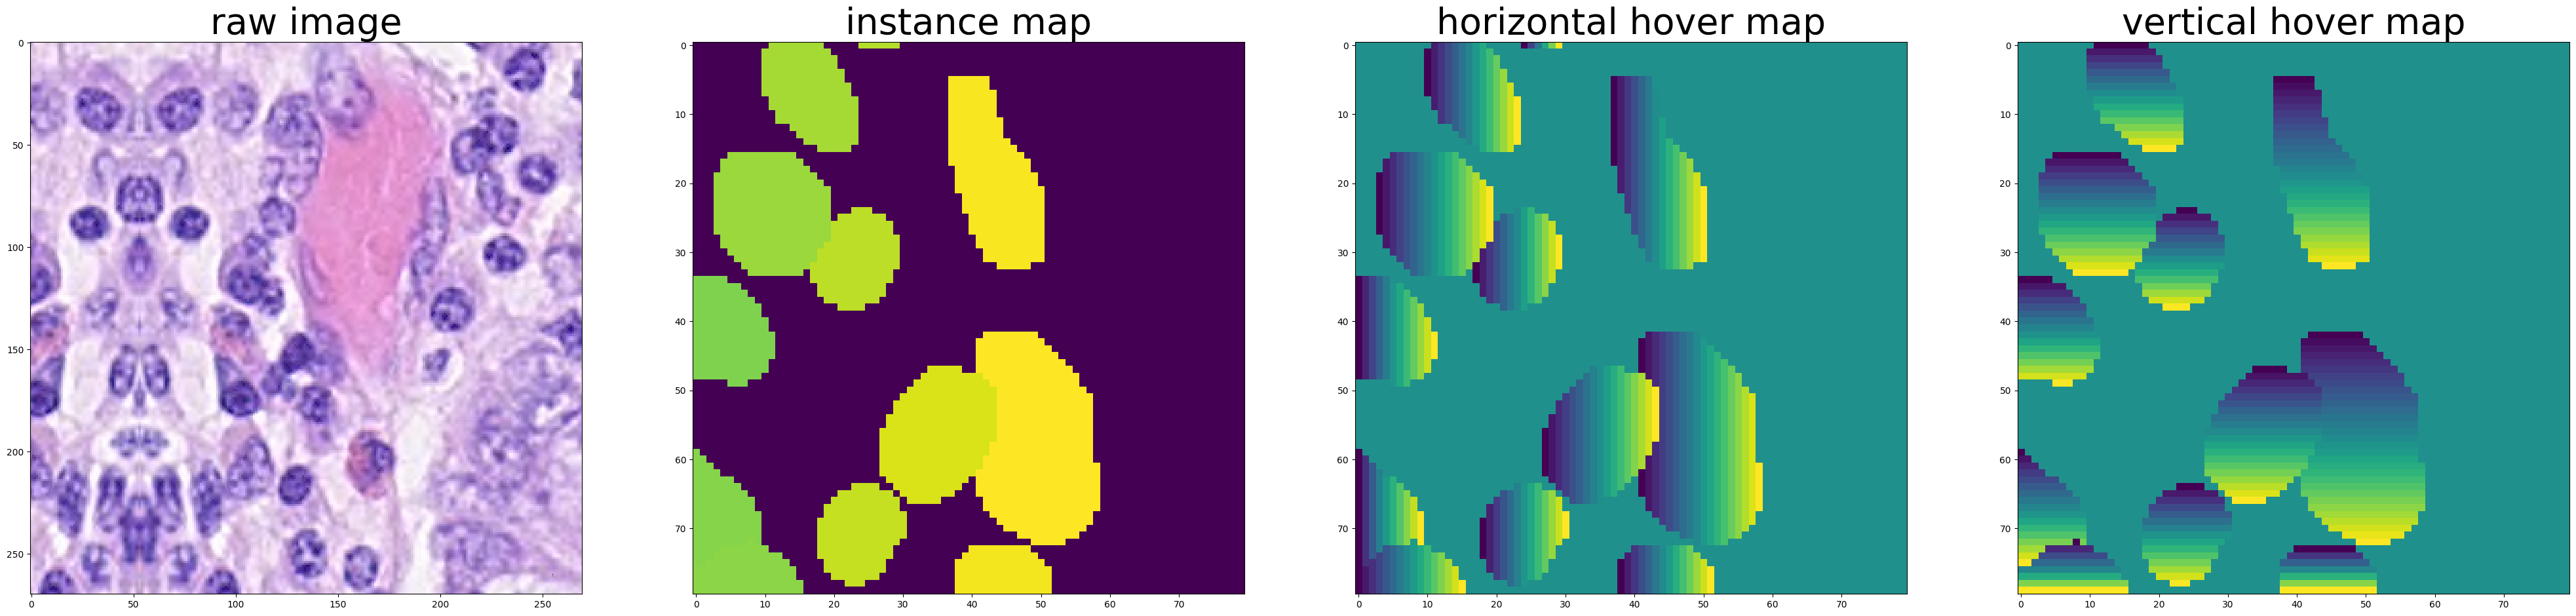

In [10]:
first_sample = first(train_loader)
for k in ("image", "label", "hover_label_inst"):
    print(f"{k}: ")
    print("    shape", first_sample[k].shape)
    print("    type: ", type(first_sample[k]))
    print("    dtype: ", first_sample[k].dtype)
print(f"train number of batches: {len(train_loader)}")
print(f"valid number of batches: {len(val_loader)}")

fig, ax = plt.subplots(1, 4, figsize=(50, 25))
ax[0].imshow((first_sample['image'][0, ...] * 255).astype(np.uint8).transpose(1, 2, 0))
ax[1].imshow(first_sample['label_inst'][0, ...].squeeze())
ax[2].imshow(first_sample['hover_label_inst'][0, 0, ...])
ax[3].imshow(first_sample['hover_label_inst'][0, 1, ...])
ax[0].set_title('raw image', fontsize=40)
ax[1].set_title('instance map', fontsize=40)
ax[2].set_title('horizontal hover map', fontsize=40)
ax[3].set_title('vertical hover map', fontsize=40)

## Create Model, Loss, Optimizer

In [9]:
device = torch.device("cuda:1")
model = HoVerNet(
    mode="original",
    in_channels=3,
    out_classes=5,
    act=("relu", {"inplace": True}),
    norm="batch",
).to(device)
loss_function = HoVerNetLoss()

# original paper
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

# lizard dataset
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.0)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [10]:
def post_process_WS(output, device, return_binary=True, return_centroids=False, output_classes=None):
    post_trans_seg = Compose([
        GenerateWatershedMaskd(keys=HoVerNetBranch.NP.value, softmax=True),
        GenerateInstanceBorderd(keys='mask', hover_map_key=HoVerNetBranch.HV, kernel_size=3),
        GenerateDistanceMapd(keys='mask', border_key='border', smooth_fn=GaussianSmooth()),
        GenerateWatershedMarkersd(keys='mask', border_key='border', threshold=0.7, radius=2, postprocess_fn=FillHoles()),
        Watershedd(keys='dist', mask_key='mask', markers_key='markers')
    ])
    if HoVerNetBranch.NC.value in output.keys():
        type_pred = Activations(softmax=True)(output[HoVerNetBranch.NC.value])
        type_pred = AsDiscrete(argmax=True)(type_pred)

    pred_inst_dict = post_trans_seg(output)
    pred_inst = pred_inst_dict['dist']

    inst_id_list = np.unique(pred_inst)[1:]  # exclude background

    inst_info_dict = None
    if return_centroids:
        inst_id_list = np.unique(pred_inst)[1:]  # exclude background
        inst_info_dict = {}
        for inst_id in inst_id_list:
            inst_map = pred_inst == inst_id
            inst_bbox = BoundingRect()(inst_map)
            inst_map = inst_map[:, inst_bbox[0][0]: inst_bbox[0][1], inst_bbox[0][2]: inst_bbox[0][3]]
            offset = [inst_bbox[0][2], inst_bbox[0][0]]
            inst_contour = GenerateInstanceContour()(inst_map.squeeze(), offset)
            inst_centroid = GenerateInstanceCentroid()(inst_map, offset)
            if inst_contour is not None:
                inst_info_dict[inst_id] = {  # inst_id should start at 1
                    "bounding_box": inst_bbox,
                    "centroid": inst_centroid,
                    "contour": inst_contour,
                    "type_probability": None,
                    "type": None,
                }

    if output_classes is not None:
        for inst_id in list(inst_info_dict.keys()):
            inst_type, type_prob = GenerateInstanceType()(
                bbox=inst_info_dict[inst_id]["bounding_box"], type_pred=type_pred, seg_pred=pred_inst, instance_id=inst_id)
            inst_info_dict[inst_id]["type"] = inst_type
            inst_info_dict[inst_id]["type_probability"] = type_prob

    pred_inst = convert_to_tensor(pred_inst, device=device)
    if return_binary:
        pred_inst[pred_inst > 0] = 1
    return (pred_inst, inst_info_dict, pred_inst_dict)

In [11]:
def _dice_info(true, pred, label):
    true = np.array(true == label, np.int32)
    pred = np.array(pred == label, np.int32)
    inter = (pred * true).sum()
    total = (pred + true).sum()
    return inter, total

In [12]:
amp = True
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()
max_epochs = 4
val_interval = 2
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], []]
epoch_loss_values = []
metric_values = []

post_process = Compose([Activations(softmax=True)])
writer = SummaryWriter()

total_start = time.time()
globel_step = 0
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        globel_step += 1 
        inputs, label, label_type, hover_map = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
            batch_data["label_type"].to(device),
            batch_data["hover_label_inst"].to(device),
        )

        labels = {
            HoVerNetBranch.NP: label,
            HoVerNetBranch.HV: hover_map,
            HoVerNetBranch.NC: label_type,
        }
        optimizer.zero_grad()
        if amp:
            with autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = loss_function(outputs.float(), labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

        lr_scheduler.step()
        epoch_loss += loss.item()
        print(f"{step}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), globel_step)

    if (epoch + 1) % val_interval == 0:
        torch.cuda.empty_cache()
        model.eval()
        over_inter = 0
        over_total = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_label = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                with torch.cuda.amp.autocast(enabled=amp):
                    val_outputs = model(val_inputs)
#                     val_outputs = [post_process_WS(i, device=device)[0] for i in decollate_batch(val_outputs)]

                # hover origin post
                val_outputs = [post_process(i[HoVerNetBranch.NP.value])[1:2, ...] > 0.5 for i in decollate_batch(val_outputs)]
                val_label = [i for i in decollate_batch(val_label)]
                for i, out in enumerate(val_outputs):
                    inter, total = _dice_info(val_label[i].detach().cpu(), out.detach().cpu(), 1)
                    over_inter += inter
                    over_total += total


                dice_metric(y_pred=val_outputs, y=val_label)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()
            dice_np = 2 * over_inter / (over_total + 1.0e-8)

            torch.save(
                model.state_dict(),
                os.path.join(writer.log_dir, f"model_{epoch}.pth"),
            )
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}, {dice_np:.4f}"
            )
            writer.add_scalar("val_mean_dice", metric, epoch + 1)
            writer.add_scalar("val_mean_dice_origin", dice_np, epoch + 1)
            plot_2d_or_3d_image(val_inputs, epoch + 1, writer, index=0, tag="image")
            plot_2d_or_3d_image(val_label, epoch + 1, writer, index=0, tag="label")
            plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

        torch.cuda.empty_cache()

    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start
print(
f"train completed, best_metric: {best_metric:.4f} "
f"at epoch: {best_metric_epoch}"
f"total time: {total_time}")

----------
epoch 1/4


Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate


1, train_loss: 11.7743
2, train_loss: 11.8486
time consuming of epoch 1 is: 2.0842
----------
epoch 2/4
1, train_loss: 11.8070
2, train_loss: 11.6975
current epoch: 2 current mean dice: 0.3800, 0.3981
time consuming of epoch 2 is: 2.9691
----------
epoch 3/4
1, train_loss: 11.6116
2, train_loss: 12.5131
time consuming of epoch 3 is: 1.5211
----------
epoch 4/4
1, train_loss: 11.6774
2, train_loss: 12.0052
current epoch: 4 current mean dice: 0.3747, 0.3925
time consuming of epoch 4 is: 2.9564


## Check best model output with the input image and label

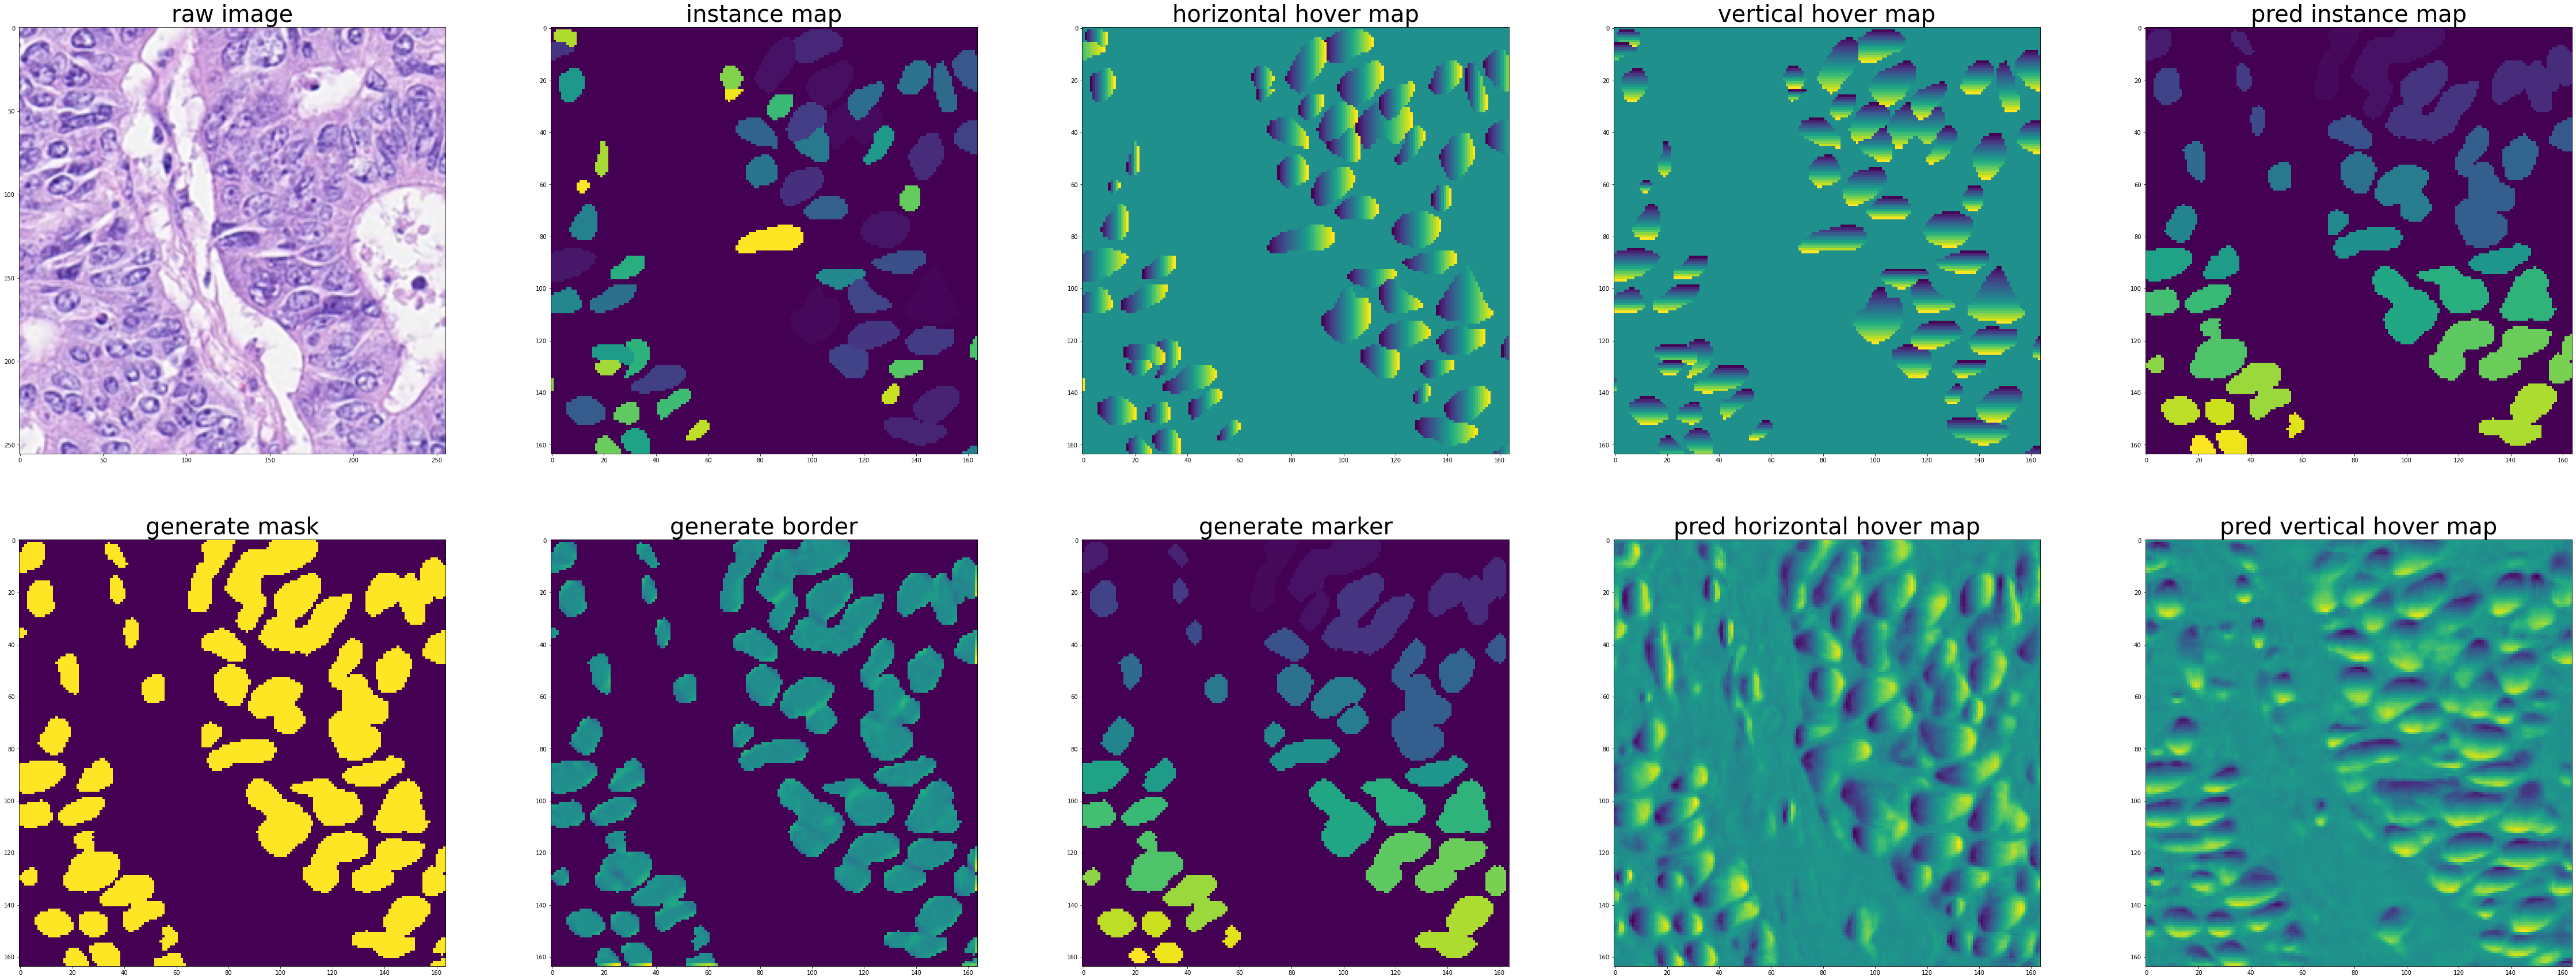

In [132]:
# test postprocess transform 
model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = valid_ds[0]["image"].unsqueeze(0).to(device)

    val_output = model(val_input)
    val_output_ = [post_process(i) for i in decollate_batch(val_output)]

    fig, ax = plt.subplots(2, 5, figsize=(80, 30))
    ax[0, 0].imshow(val_input.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
    ax[0, 1].imshow(valid_ds[0]["label_inst"].squeeze().detach().cpu())
    ax[0, 2].imshow(valid_ds[0]["hover_label_inst"][0, ...].detach().cpu())
    ax[0, 3].imshow(valid_ds[0]["hover_label_inst"][1, ...].detach().cpu())
    ax[0, 4].imshow(val_output_[0][0].squeeze().detach().cpu())

    ax[1, 0].imshow(val_output_[0][2]["mask"].detach().cpu().squeeze())
    ax[1, 1].imshow(val_output_[0][2]["border"].detach().cpu().squeeze())
    ax[1, 2].imshow(val_output_[0][2]["markers"].detach().cpu().squeeze())
    ax[1, 3].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[0, ...])
    ax[1, 4].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[1, ...])

    ax[0, 0].set_title('raw image', fontsize=40)
    ax[0, 1].set_title('instance map', fontsize=40)
    ax[0, 2].set_title('horizontal hover map', fontsize=40)
    ax[0, 3].set_title('vertical hover map', fontsize=40)
    ax[0, 4].set_title('pred instance map', fontsize=40)
    ax[1, 0].set_title('generate mask', fontsize=40)
    ax[1, 1].set_title('generate border', fontsize=40)
    ax[1, 2].set_title('generate marker', fontsize=40)
    ax[1, 3].set_title('pred horizontal hover map', fontsize=40)
    ax[1, 4].set_title('pred vertical hover map', fontsize=40)